# Сгенерировано или нет

**В данном проекте мы будем строить модель способную отличать сгенерированное изображение от реального.**

Для работы у нас есть следующие данные:
* Корпус изображений, один сразу для стадии обучения и теста
* 2 файла .csv для тренировки модели с разметкой и файла и с именами файлов для финального тестирования итоговой модели.

В ходе работы внимательно изучим данные, посмотрим какие сведения из данных получится использовать дополнительно. Затем напишем все вспомогательные функции. Далее построим бейзлайн-модель с использованием предобученной модели EfficentnetB4. Затем протестируем несколько моделей и способов добиться требуемой цели.

Для оценки модели необходимо использовать метрику LogLoss, а результат перевести в файл .csv  по предложенному примеру.

### Импортируем необходимые библиотеки и сразу установим некоторые константы.

In [ ]:
import gc
import os
from pathlib import Path

import imagesize
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from pylab import rcParams
from skimage import color
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.transforms import InterpolationMode, v2
from tqdm import tqdm, trange

rcParams["figure.figsize"] = 12, 7

SEED = 777
DATA_ROOT = Path("data/")


## EDA

Посмотрим на наши данные, на списки файлов в .csv  и на сами изображения

In [4]:
train_df = pd.read_csv(DATA_ROOT.joinpath("train.csv"))
test_df = pd.read_csv(DATA_ROOT.joinpath("test.csv"))
train_df.head(6), test_df.head(6)

(                id  target
 0   gL5fWrgNPU.jpg       0
 1   KKWXJDN8uM.png       1
 2   Wb2I0CXlAY.jpg       0
 3  G7PLhKpaf7.jpeg       1
 4   DEUkeefz6Z.jpg       0
 5   enth8MGCce.jpg       0,
                 id
 0  Qt1fGUB0Vz.jpeg
 1  j4Rhioq7R3.jpeg
 2  rD0hgFHJUZ.jpeg
 3  aY5z1EJsJ6.jpeg
 4  qZ3IoxD2TE.jpeg
 5  BOFtxEERkV.jpeg)

In [5]:
train_df.info()
print("\n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1012 non-null   object
 1   target  1012 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.9+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      506 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


Мы имеем 1012 размеченных изображений для тренировки и еще 506 изображений для тестирования модели.

Можно заметить, что файлы изображений имеют разный формат и расширение файла не всегда указано в имени, это будет вызывать проблемы при обращении к имени как к пути.

Посмотрим какие у имен файлов есть расширения и как они количественно распределяются в таблицах `train_df` и `test_df`.

Также считаем имена и расширения всех файлов изображений в отдельную таблицу `divide_df` и посмотрим как они распределяются

In [6]:
def unique_extension(datafile: pd.Series):
    return datafile.str.split(".").apply(lambda x: x[-1]).value_counts()


print("Train extension distribution: \n", unique_extension(train_df.id), "\n")
print("Test extension distribution: \n", unique_extension(test_df.id))

Train extension distribution: 
 id
jpg           667
jpeg          171
png             8
FXi7ZuLayj      1
t0ALW3uGB4      1
             ... 
zlskYihnhe      1
5Mk5pJbr6T      1
MBvR6aiYYZ      1
4CTRMzDhq9      1
v69Xk6ipWU      1
Name: count, Length: 169, dtype: int64 

Test extension distribution: 
 id
jpeg          420
webp            2
Rd69o4ssKn      1
20kFo0P1BQ      1
1fTEAJtDVV      1
             ... 
2NgC4tf6eo      1
MjSOVP4B8S      1
oQQR8GD9Jo      1
3799mntej2      1
5zgwAc5vfr      1
Name: count, Length: 86, dtype: int64


In [7]:
all_images_split = [
    image.split(".") for image in os.listdir(DATA_ROOT.joinpath("images"))
]
divide_df = pd.DataFrame(all_images_split, columns=["name", "im_format"])

divide_df.head()

name im_format
0  YC74CENUBg       png
1  nCnUACoyVb       jpg
2  TevFHDsqVC       jpg
3  NYOMKoX0pw       png
4  HmlE9CeaPQ      jpeg

In [8]:
print("All files extension distribution: \n", unique_extension(divide_df.im_format))

All files extension distribution: 
 im_format
jpg     667
jpeg    591
png     258
webp      2
Name: count, dtype: int64


Видно, что большая часть имен файлов как в обучающей части так и в тестовой имеет формат jpeg/jpg, несколько изображений в формате png и webp. У остальных имен файлов (около 17%) отсутствует расширение. При этом сами файлы имеют корректные расширения и, судя по их количеству, можно предположить, что отсутствующие расширения у имен файлов это .png

**Откорректируем имена файлов в наших csv таблицах**

Чтобы исключить ошибку - разделим существующие имена в файлах на имя и расширение, затем по имени файла подтянем корректное расширение из `divide_df` и запишем в столбец `cor_id`. 

In [9]:
def filename_divide(datafile: pd.DataFrame):
    datafile["name"] = datafile["id"].str.split(".").str[0]
    datafile["format"] = datafile["id"].str.rsplit(".").str[1]
    return datafile


train_df = filename_divide(train_df)
test_df = filename_divide(test_df)
train_df.head(8)

id  target        name format
0   gL5fWrgNPU.jpg       0  gL5fWrgNPU    jpg
1   KKWXJDN8uM.png       1  KKWXJDN8uM    png
2   Wb2I0CXlAY.jpg       0  Wb2I0CXlAY    jpg
3  G7PLhKpaf7.jpeg       1  G7PLhKpaf7   jpeg
4   DEUkeefz6Z.jpg       0  DEUkeefz6Z    jpg
5   enth8MGCce.jpg       0  enth8MGCce    jpg
6       hG9nlBfDeh       1  hG9nlBfDeh    NaN
7   Re69C5wIs7.jpg       0  Re69C5wIs7    jpg

In [10]:
def correct_ext(df_incorrect: pd.DataFrame, df_full: pd.DataFrame):
    df_incorrect = df_incorrect.merge(df_full, on="name", how="left")
    df_incorrect["cor_id"] = df_incorrect["name"] + "." + df_incorrect["im_format"]
    return df_incorrect


test_df = correct_ext(test_df, divide_df)
train_df = correct_ext(train_df, divide_df)
train_df.head(7)

id  target        name format im_format           cor_id
0   gL5fWrgNPU.jpg       0  gL5fWrgNPU    jpg       jpg   gL5fWrgNPU.jpg
1   KKWXJDN8uM.png       1  KKWXJDN8uM    png       png   KKWXJDN8uM.png
2   Wb2I0CXlAY.jpg       0  Wb2I0CXlAY    jpg       jpg   Wb2I0CXlAY.jpg
3  G7PLhKpaf7.jpeg       1  G7PLhKpaf7   jpeg      jpeg  G7PLhKpaf7.jpeg
4   DEUkeefz6Z.jpg       0  DEUkeefz6Z    jpg       jpg   DEUkeefz6Z.jpg
5   enth8MGCce.jpg       0  enth8MGCce    jpg       jpg   enth8MGCce.jpg
6       hG9nlBfDeh       1  hG9nlBfDeh    NaN       png   hG9nlBfDeh.png

**Для исключения ликов далее будем рассматривать только изображения из набора для обучения модели `train_df`**

Посмотрим как распределяется целевой класс в нашем наборе изображений.

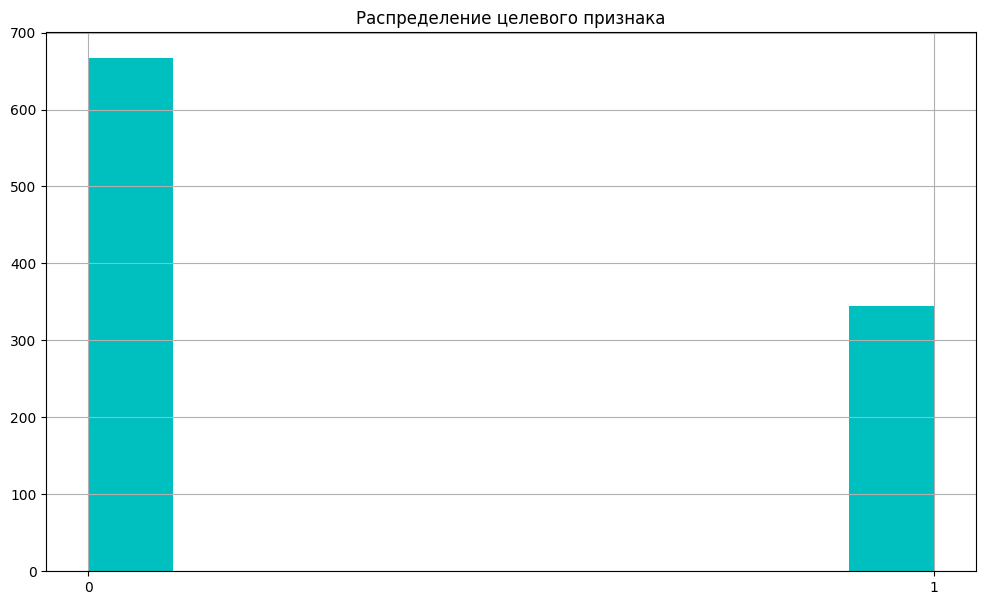

In [11]:
train_df.target.hist(color="c")
plt.title("Распределение целевого признака")
plt.xticks([0, 1], ["0", "1"])
plt.show()

Добавим в нашу таблицу столбец `image_size` и запишем в него размеры каждого изображения из тренировочного набора и сразу же посмотрим на то какие размеры изображений преобладают в датасете относительно целевого класса.

In [12]:
train_df["image_size"] = [
    imagesize.get(DATA_ROOT.joinpath("images/" + file)) for file in train_df["cor_id"]
]
train_df.head(7)

id  target        name format im_format           cor_id  \
0   gL5fWrgNPU.jpg       0  gL5fWrgNPU    jpg       jpg   gL5fWrgNPU.jpg   
1   KKWXJDN8uM.png       1  KKWXJDN8uM    png       png   KKWXJDN8uM.png   
2   Wb2I0CXlAY.jpg       0  Wb2I0CXlAY    jpg       jpg   Wb2I0CXlAY.jpg   
3  G7PLhKpaf7.jpeg       1  G7PLhKpaf7   jpeg      jpeg  G7PLhKpaf7.jpeg   
4   DEUkeefz6Z.jpg       0  DEUkeefz6Z    jpg       jpg   DEUkeefz6Z.jpg   
5   enth8MGCce.jpg       0  enth8MGCce    jpg       jpg   enth8MGCce.jpg   
6       hG9nlBfDeh       1  hG9nlBfDeh    NaN       png   hG9nlBfDeh.png   

     image_size  
0    (500, 375)  
1    (512, 512)  
2    (375, 500)  
3  (1024, 1024)  
4    (500, 375)  
5    (500, 375)  
6    (742, 650)

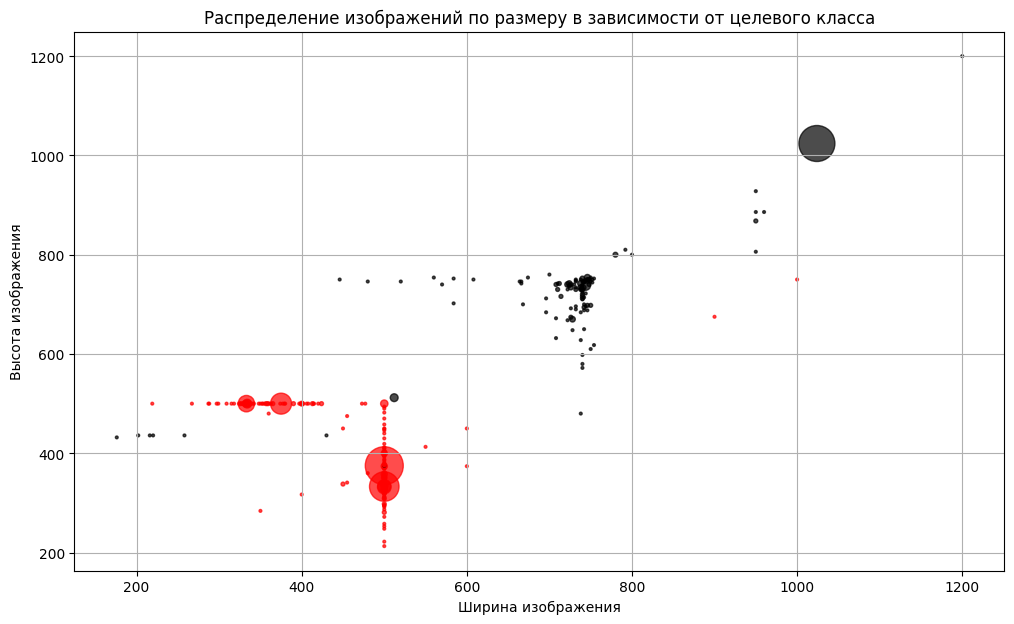

In [13]:
df_group = pd.pivot_table(
    train_df,
    index=["image_size", "target"],
    values=["name"],
    aggfunc="count",
    fill_value=0,
).reset_index()

plt.scatter(
    *zip(*df_group.image_size),
    c=df_group.target,
    s=df_group.name * 4,
    alpha=0.7,
    cmap="flag",
)
plt.title("Распределение изображений по размеру в зависимости от целевого класса")
plt.grid()
plt.xlabel("Ширина изображения")
plt.ylabel("Высота изображения")
plt.show()

Далее отобразим какие форматы изображений преобладают у какого целевого класса.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


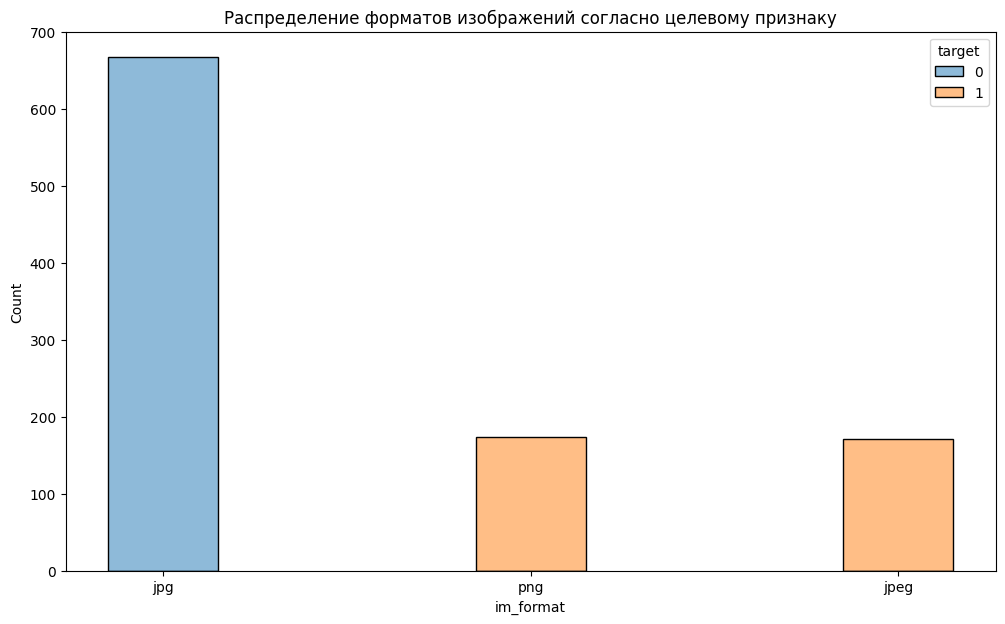

In [14]:
sns.histplot(train_df, x="im_format", hue="target", shrink=0.3)
plt.title("Распределение форматов изображений согласно целевому признаку");

Теперь посмотрим несколько изображений из датасета, их целевой класс и размер.

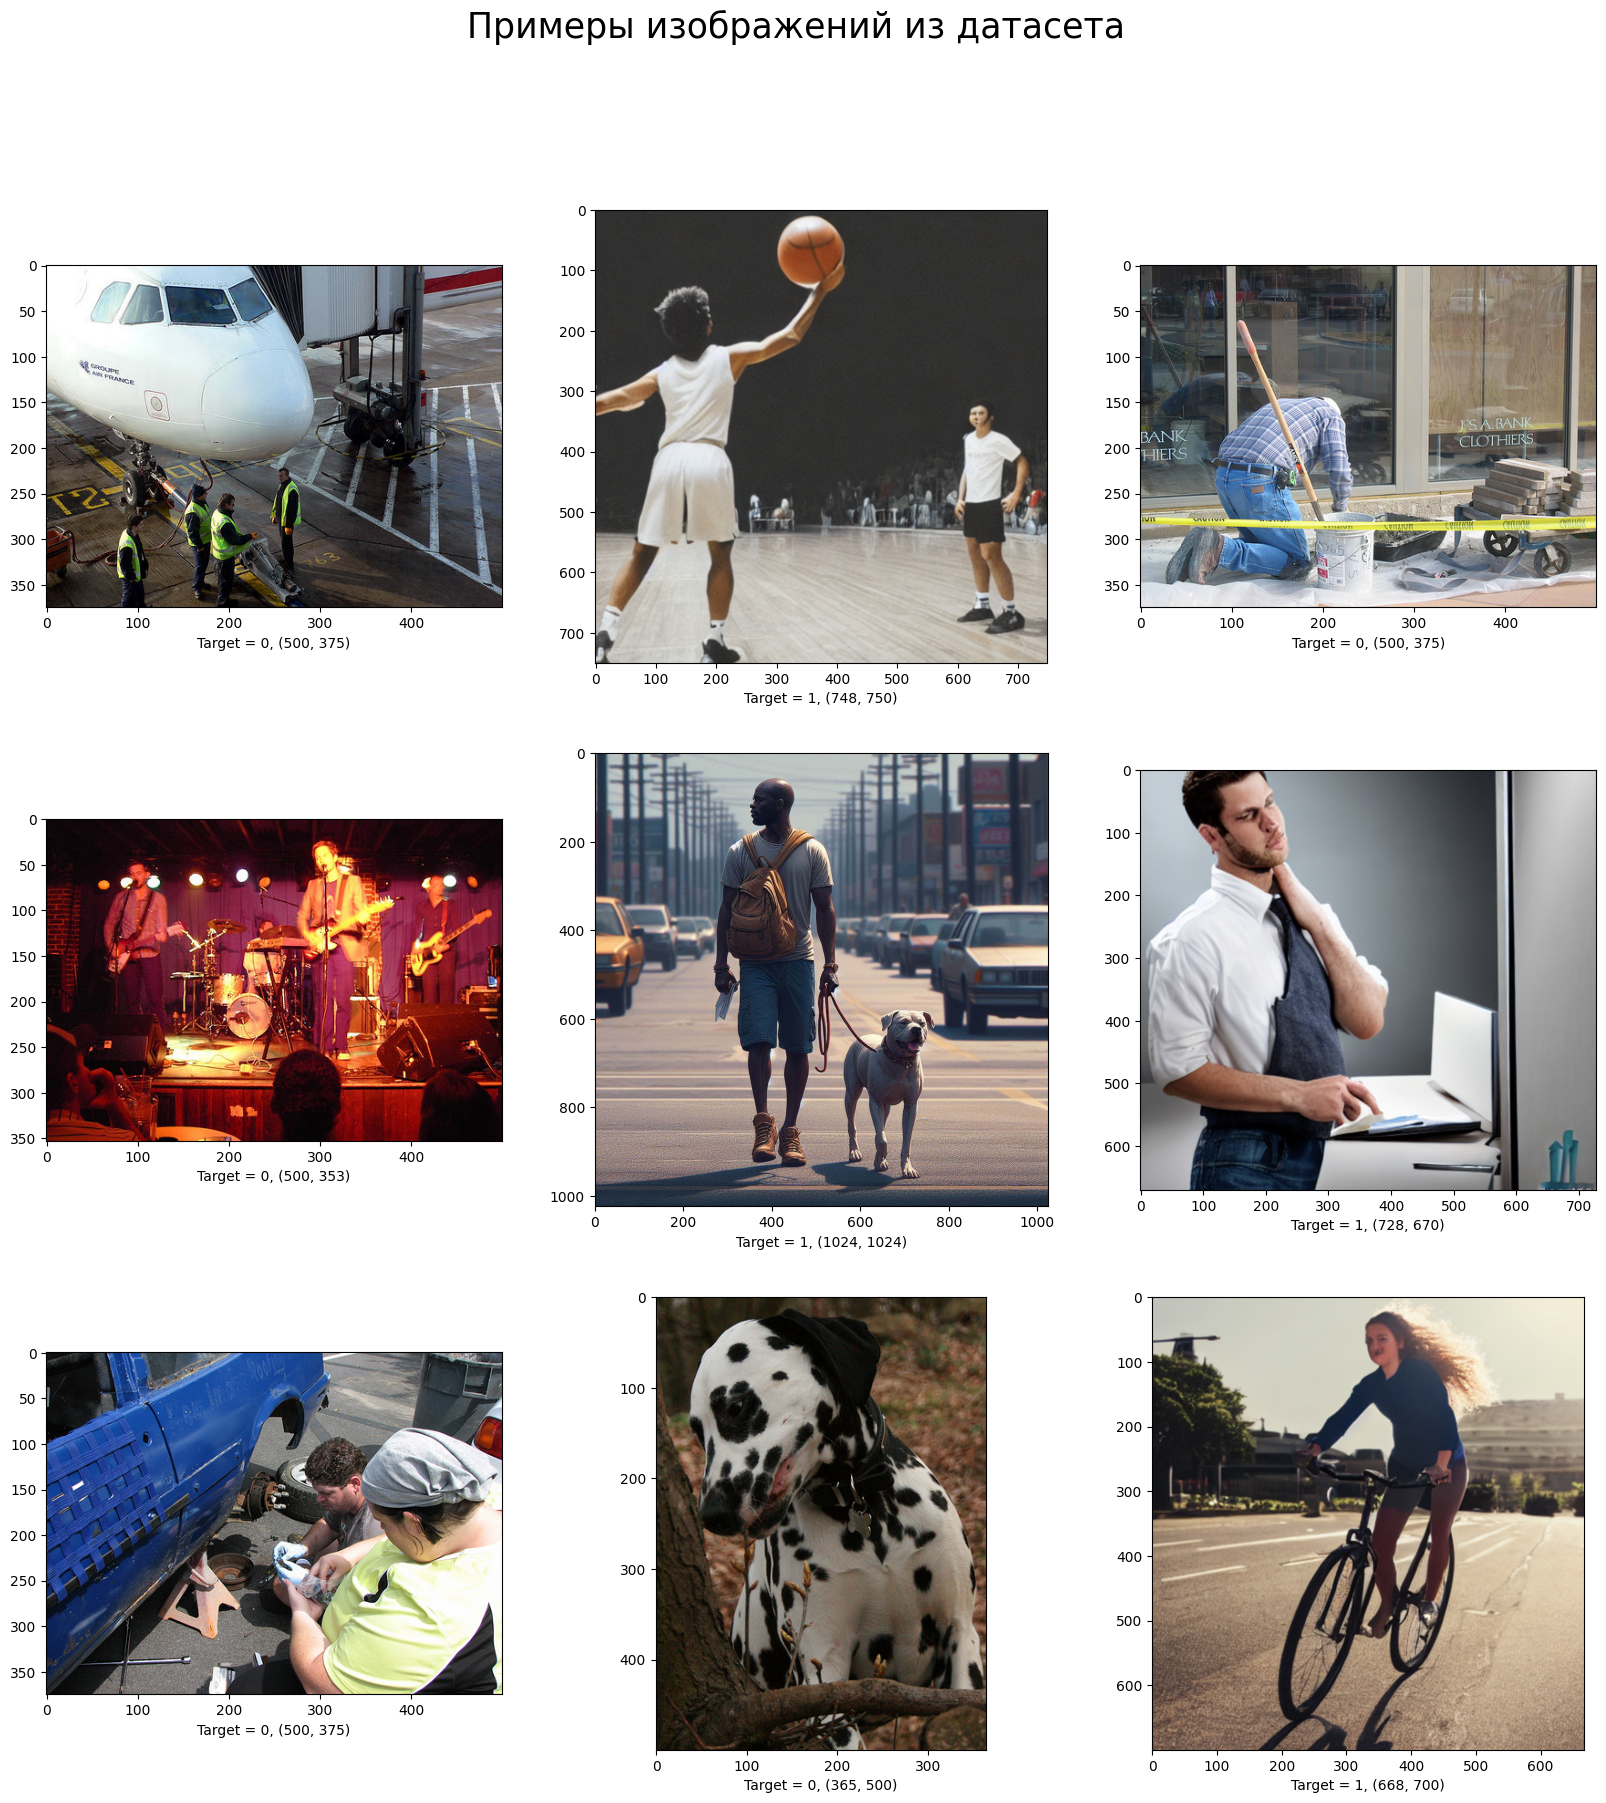

In [15]:
fig, ax = plt.subplots(3, 3)
fig.suptitle("Примеры изображений из датасета", fontsize=25)
fig.set_figwidth(20)
fig.set_figheight(20)
c = 150
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(
            plt.imread(DATA_ROOT.joinpath("images/" + train_df.cor_id[c + j]))
        )
        ax[i, j].set_xlabel(
            f"Target = {train_df.target[c + j]}, {train_df.image_size[c + j]}"
        )
    c += j + 1

**Добавим все изображения для тренировки модели в переменную X**

In [16]:
X = [imread(DATA_ROOT.joinpath("images/" + file)) for file in train_df.cor_id]

len(X)

1012

Теперь посмотрим сколько каналов имеет каждое изображение и как они распределяются между целевыми признаками

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

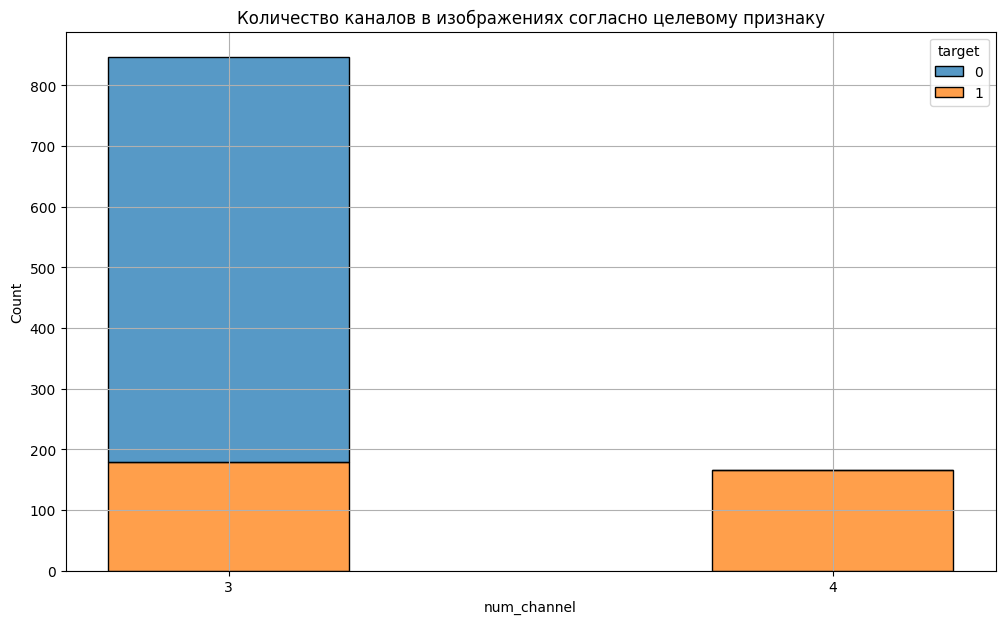

In [17]:
train_df["num_channel"] = [x.shape[2] for x in X]

sns.histplot(
    train_df[["num_channel", "target"]],
    x="num_channel",
    hue="target",
    multiple="stack",
    discrete=True,
    shrink=0.4,
)
plt.title("Количество каналов в изображениях согласно целевому признаку")
plt.xticks([3, 4], ["3", "4"])
plt.grid()
plt.show()

**Выводы и наблюдения:**

Мы имеем очень небольшой датасет с изображениями (1012 изображений для тренировки и 506 для тестирования) относящиеся к 2-м классам: 
- класс 0 - реальные изображения(фотографии) людей и животных в различных ситуациях, разном количество и масштабе;
- класс 1 - сгенерированные изображения человека или животных и окружающего их пространства. Качество генерации очень сильно различается от изображения к изображению, в некоторых случаях заметные явные артефакты и неточности генерации. В других случаях генерация очень качественная.

При этом мы имеем некоторый дисбаланс классов и реальных изображений у нас в 2 раза больше сгенерированных. Также изображения разных классов довольно сильно различаются между собой:
* Почти все реальные изображения имеют прямоугольный формат и в своих размерах практически не выходят за пределы 500 пикселей. При этом сгенерированные изображения почти во всех случаях имеют значительно больший размер и могут быть как прямоугольными, так и квадратными;
* Все реальные изображения имеют расширение `.jpg`, а у всех сгенерированных расширения `.jpeg` и `.png`;
* Количество цветовых каналов у реальных изображений всегда 3, тогда как у сгенерированных может быть как 3 так и 4.

Таким образом мы видим, что если рассчитывать только на данный датасет, то довольно легко отсеять сгенерированные варианты по их размеру и формату. Однако при этом такой алгоритм запнется при любом отклонении от данных правил.<br>
В итоге модель для распознавания понадобится качественная, способная отличать не только классы объектов на изображении, но и замечать артефакты и шум отличающие сгенерированные изображения. При этом мы не будем добавлять в модель дополнительные фичи в виде размера или типа формата изображения, чтобы при обучении веса модели не смещались в сторону этих признаков и модель не теряла свою обобщающую способность.

## Подготовка данных к обучению 

Переведём все изображения для тренировки модели в формат RGB с тремя каналами.

In [18]:
X = [color.rgba2rgb(image) if image.shape[2] == 4 else image for image in X]

Также запишем целевой признак в переменную `Y` и переведём в формат массива.

In [19]:
Y = np.array(train_df.target, np.float32)
Y

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

Разделим данные для тренировки модели на собственно тренировочную часть и валидационную для оценки модели во время тренировки

In [20]:
train_X, val_X, train_Y, val_Y = train_test_split(
    X, Y, test_size=0.22, random_state=SEED, stratify=Y
)


for df in [train_X, val_X, train_Y, val_Y]:
    print(len(df))

789
223
789
223


## Подготовка вспомогательных функций для последующего обучения и тестирования модели

Сразу проверим наличие gpu для работы.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


Создадим класс `FakeDataset`для конвертации данных в подходящий формат

In [22]:
class FakeDataset(Dataset):
    def __init__(self, images, transform, labels=False):
        """
        Arguments:
            images (List):  List with np.array-images (H x W x C)
            labels (np.array): labels of target class.
            transform (callable): Transform to be applied on a sample.
        """
        self.images = images

        self.labels = labels

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx])

        if isinstance(self.labels, bool):
            return image

        else:
            sample = [image, self.labels[idx]]
            return sample

Также подготовим базовые преобразования  для наших данных

In [23]:
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(
                384, interpolation=InterpolationMode.BILINEAR, antialias=True
            ),
            transforms.CenterCrop(380),
            v2.ToDtype(torch.float32),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(
                384, interpolation=InterpolationMode.BILINEAR, antialias=True
            ),
            transforms.CenterCrop(380),
            v2.ToDtype(torch.float32),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

Подготовим функцию для основной тренировки модели и визуализации результатов обучения. Во время обучения будем измерять требуемую метрику `logloss` и дополнительную `accuracy` для понимания точности работы модели.

In [24]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    val_loss = []
    val_acc = []

    pbar = trange(epochs, desc="Epoch:")

    for epoch in pbar:
        avg_acc = 0
        avg_loss = 0
        avg_val_loss = 0

        model.train()

        for X_batch, Y_batch in tqdm(
            data_tr, leave=True, total=len(data_tr), desc=f"{data_tr} iter:"
        ):
            if torch.cuda.is_available():
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            else:
                X_batch, Y_batch = X_batch, Y_batch
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(torch.squeeze(Y_pred), Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss

        avg_loss = avg_loss / len(data_tr)
        scheduler.step()

        print("train_loss: %f" % avg_loss)

        model.eval()

        for X_batch, Y_batch in data_val:
            if torch.cuda.is_available():
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            else:
                X_batch, Y_batch = X_batch, Y_batch

            with torch.no_grad():
                Y_pred = model(X_batch)

            loss = loss_fn(torch.squeeze(Y_pred), Y_batch)
            acc = sum(torch.squeeze(Y_pred > 0.5) == Y_batch) / len(Y_batch)

            print(f" Batch accuracy {acc.item()}")

            avg_val_loss += loss
            avg_acc += acc

        avg_val_loss = avg_val_loss / len(data_val)
        avg_acc = avg_acc / len(data_val)

        clear_output(wait=True)

        print("val_loss: %f" % avg_val_loss)
        print("val_accuracy: %f" % avg_acc)

        val_loss.append(avg_val_loss.to("cpu"))
        val_acc.append(avg_acc.to("cpu"))

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    ax[0].plot(range(1, epochs + 1), val_loss, label="validation loss", color="blue")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Validation loss")
    ax[1].plot(
        range(1, epochs + 1),
        val_acc,
        label="validation accuracy",
        color="green",
    )
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Validation accuracy")
    plt.show()

    return val_loss

Функция для обучения финальной выбранной модели на полных тренировочных данных

In [25]:
def train_full(model, opt, loss_fn, epochs, data_full, scheduler):
    pbar = trange(epochs, desc="Epoch:")

    for epoch in pbar:
        avg_loss = 0

        model.train()
        for X_batch, Y_batch in tqdm(
            data_full, leave=True, total=len(data_full), desc=f"{data_full} iter:"
        ):
            if torch.cuda.is_available():
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            else:
                X_batch, Y_batch = X_batch, Y_batch

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(torch.squeeze(Y_pred), Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss

        avg_loss = avg_loss / len(data_full)
        scheduler.step()

        clear_output(wait=True)
        print("train_loss: %f" % avg_loss)

    return model

Функция для получения результата работы модели на тестовых данных

In [26]:
def predict(
    file_names,
    model,
    data_root,
    transform=img_transforms["val"],
    batch_size=8,
    num_workers=0,
):
    images = [
        imread(data_root.joinpath("images/" + file)) for file in file_names.cor_id
    ]

    images = [
        color.rgba2rgb(image) if image.shape[2] == 4 else image for image in images
    ]
    images_set = FakeDataset(images, transform=transform)
    image_loader = DataLoader(
        images_set, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    preds = torch.tensor([])
    model.eval()
    for batch in tqdm(
        image_loader, leave=True, total=len(image_loader), desc=f"{image_loader} iter:"
    ):
        if torch.cuda.is_available():
            batch = batch.to(device)
        else:
            batch = batch

        with torch.no_grad():
            prediction = model(batch)
        preds = torch.cat((preds, prediction.cpu()), dim=0)

    file_names["target"] = preds
    submission = file_names.loc[:, ("id", "target")]

    return submission

## Baseline 

Для модели baseline выбрана предобученная модель `efficientnet_b4`. Модель отлично себя показывает при распознавании изображений и при этом имеет  хорошее быстродействие. Для базового варианта обучим только классификатор модели, а все остальные слои оставим с предобученными весами без изменений.

Сначала преобразуем данные в необходимый формат для обучения модели

In [27]:
data_train = FakeDataset(train_X, labels=train_Y, transform=img_transforms["train"])
data_val = FakeDataset(val_X, labels=val_Y, transform=img_transforms["val"])

In [28]:
batch_size = 32

if torch.cuda.is_available():
    num_workers = 2
else:
    num_workers = 0

dataloader_train = DataLoader(
    data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

dataloader_val = DataLoader(
    data_val, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

next(iter(dataloader_train))[0].shape

torch.Size([32, 3, 380, 380])

Посмотрим на изображения, подготовленные для модели

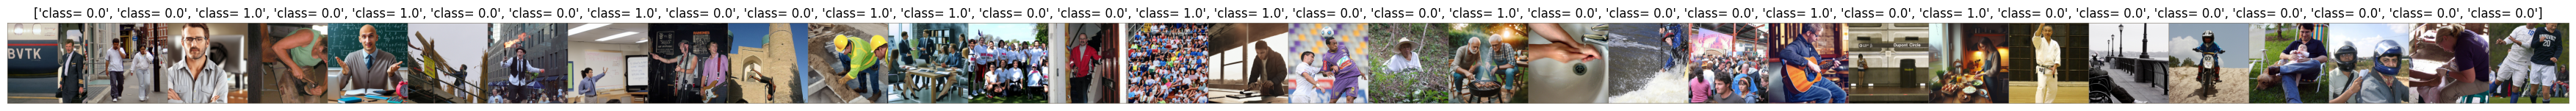

In [29]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(45, 12))

    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


images, targets = next(iter(dataloader_train))

out = torchvision.utils.make_grid(images, nrow=batch_size)

imshow(out, title=[f"class= {x.item()}" for x in targets])

Загрузим модель и подготовим слой классификатора для обучения

In [30]:
model = models.efficientnet_b4(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 84.4MB/s]


In [31]:
for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=num_features, out_features=1, bias=True),
    nn.Sigmoid(),
)

model = model.to(device)

In [32]:
# model

Определим функцию потерь, оптимизатор для обучения модели, и способ изменения learning_rate для оптимизатора.

In [33]:
loss_fn = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

step_lr = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Обучим нашу baseline модель на 16-ти эпохах и посмотрим на результат.

Epoch:: 100%|██████████| 16/16 [03:23<00:00, 12.72s/it]

val_loss: 0.538497
val_accuracy: 0.739631


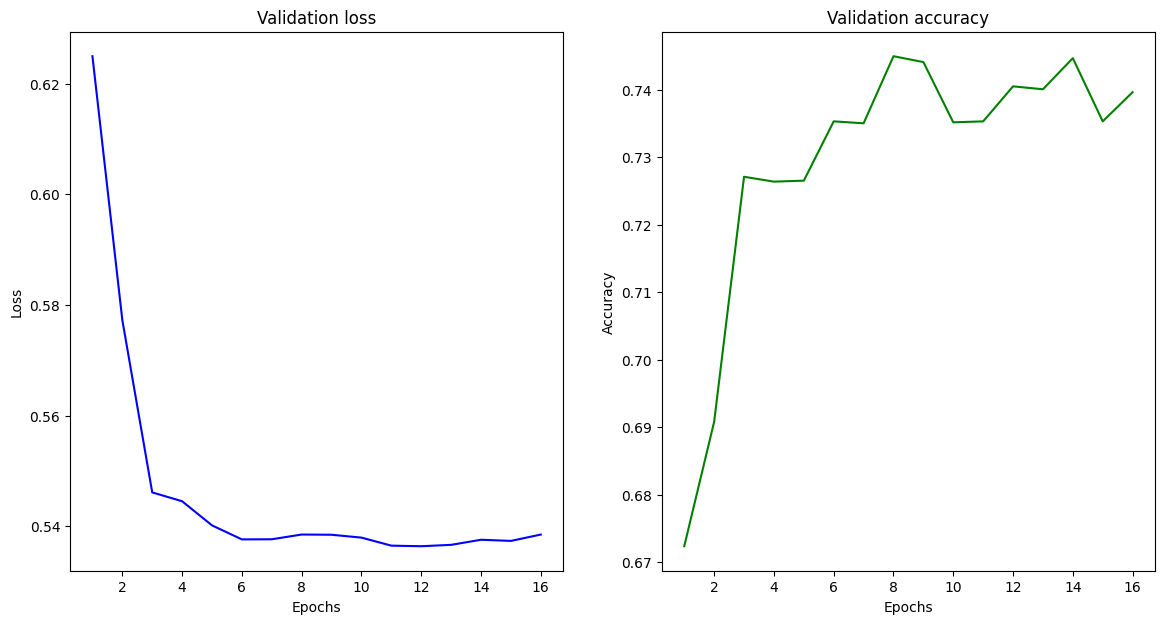

In [34]:
losses = train(
    model=model,
    opt=optimizer,
    loss_fn=loss_fn,
    epochs=16,
    data_tr=dataloader_train,
    data_val=dataloader_val,
    scheduler=step_lr,
)

Наш бэйзлан достиг метрики `log_loss` = 0.538, при значениях точности `accuracy` = 0.7396. При этом по графикам обучения видно что `log_loss` вышла на постоянные показания, а точность немного болтается от эпохи к эпохи в +/- двух процентов.


## Подбор основной модели и гиперпараметров

### Основные гипотезы и предположения для поиска решения

**Данных очень мало для качественного обучения больших моделей. Это также приводит к необходимости использовать аугментацию как основной инструмент увеличение данных.**<br>
*Быстрая попытка дообучения более "тяжелых" моделей не дала лучшего результата.*

**В связи с тем, что нам достаточно получить одну метку на выходе модели появляется следующее предположение - можно использовать простую, непредобученную сверточную сеть для поиска паттернов, шума, или общих черт сглаживания (например), которые будут общими для реальных или сгенерированных изображений. Алгоритм будет плохо работать на распознавание классов изображенных предметов, но возможно будет улавливать какие-либо общие паттерны генерации.**<br>
*Простая сверточная сеть плавно преобразующая изображение 234х234 в плоский вектор длиной 256 показала результаты хуже выбранного метода.*

**В случае использования предобученной модели необходимо помнить, что модели классификации обучены на распознавание конкретных классов изображений и стремятся находить их, а в нашем случае даже при наличии определенного класса изображения необходимо распознавать его как сгенерированное изображение. Это подводит к тому, что дообучение только лишь классификатора модели может быть недостаточным для достижения более точных результатов.**

**Нельзя отрицать вариант со сбором собственного датасета на основе открытых данных и обучения большой модели на всех данных. Но для этого варианта необходимы вычислительные ресурсы и большое количество времени.**<br>
*Протестировано добавление данных с соревнования [huggingface_aiornot](https://huggingface.co/datasets/competitions/aiornot) - оценка ниже выбранного варианта из-за специфики датасета - много произведений искусства созданных человеком или сгенерированных.*

---- 
После проработки нескольких более и менее удачных вариантов был выбран следующий вариант - Мы берем предобученную модель `EfficientNet_V2_S`. Это модель следующего поколения из семейства EfficientNet, она имеет более высокую скорость обучения и лучшую эффективность. Мы будем использовать модель `S`- самую маленькую модель в семействе, так как имеем ограниченное количество данных. Классификатор модели сделаем в виде 2х линейных слоев, первый слой оставим с выходом  1000 так как изначально модель обучалась именно на этот вариант. Во втором линейном слое будет выход на одно значение - финальная вероятность . Дообучение модели будем проводить по всем слоям, чтобы модель могла уловить и низко, и высокоуровневые изменения на изображениях. Для данных применим уменьшение размерности до 440х440 пикселей, последующий `RandomCrop` с размером изображения 384(тот размер на который была изначально обучена модель) и различные аугментации. 


### Обучение выбранной модели

Загрузим предобученную модель `EfficientNet_V2_S` и обучим ее на наших данных. <br>
Для обучения будем использовать оптимизатор `NAdam`,<br>
ступенчатое изменение learning_rate с помощью `r_scheduler.StepLR`,<br>
21 эпоху.

In [35]:
gc.collect()

torch.cuda.empty_cache()

In [36]:
weights_v2_s = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1

model_v2_s = models.efficientnet_v2_s(weights_v2_s)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 156MB/s] 


Переопределим переменную преобразовывающую изображение и добавим в нее аугментации

In [37]:
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(
                440, interpolation=InterpolationMode.BILINEAR, antialias=True
            ),
            transforms.CenterCrop(440),
            transforms.RandomCrop(size=384, pad_if_needed=True),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
            transforms.RandomRotation(degrees=(0, 80)),
            transforms.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(
                384, interpolation=InterpolationMode.BILINEAR, antialias=True
            ),
            transforms.CenterCrop(384),
            v2.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

Подготовим датасет с новым набором трансформаций и аугментаций

In [ ]:
batch_size = 32

data_train = FakeDataset(train_X, labels=train_Y, transform=img_transforms["train"])
data_val = FakeDataset(val_X, labels=val_Y, transform=img_transforms["val"])

dataloader_train = DataLoader(
    data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

dataloader_val = DataLoader(
    data_val, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

Посмотрим на подготовленные к обучению изображения

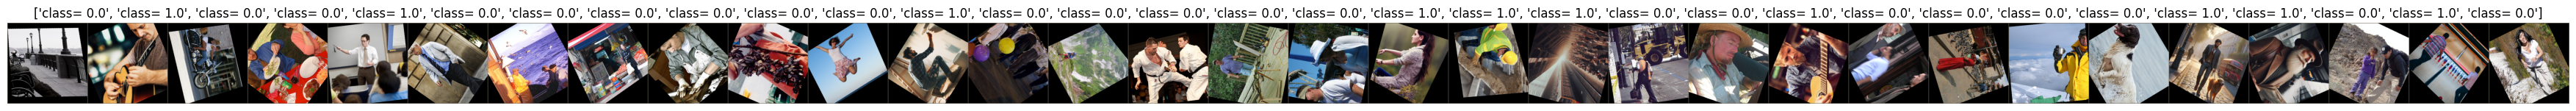

In [39]:
images, targets = next(iter(dataloader_train))

out = torchvision.utils.make_grid(images, nrow=batch_size)

imshow(out, title=[f"class= {x.item()}" for x in targets])

Преобразуем голову модели и запустим обучение

In [40]:
for param in model_v2_s.parameters():
    param.requires_grad = True

num_features = model_v2_s.classifier[1].in_features  # 1280

model_v2_s.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=num_features, out_features=1000, bias=True),
    nn.SiLU(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1000, out_features=1, bias=False),
    nn.Sigmoid(),
)

model_v2_s = model_v2_s.to(device)

In [41]:
# model_v2_s

In [ ]:
loss_fn = nn.BCELoss()


optimizer = optim.NAdam(model_v2_s.parameters(), lr=1e-3)


step_lr = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

Epoch:: 100%|██████████| 21/21 [09:51<00:00, 28.17s/it]

val_loss: 0.006739
val_accuracy: 1.000000


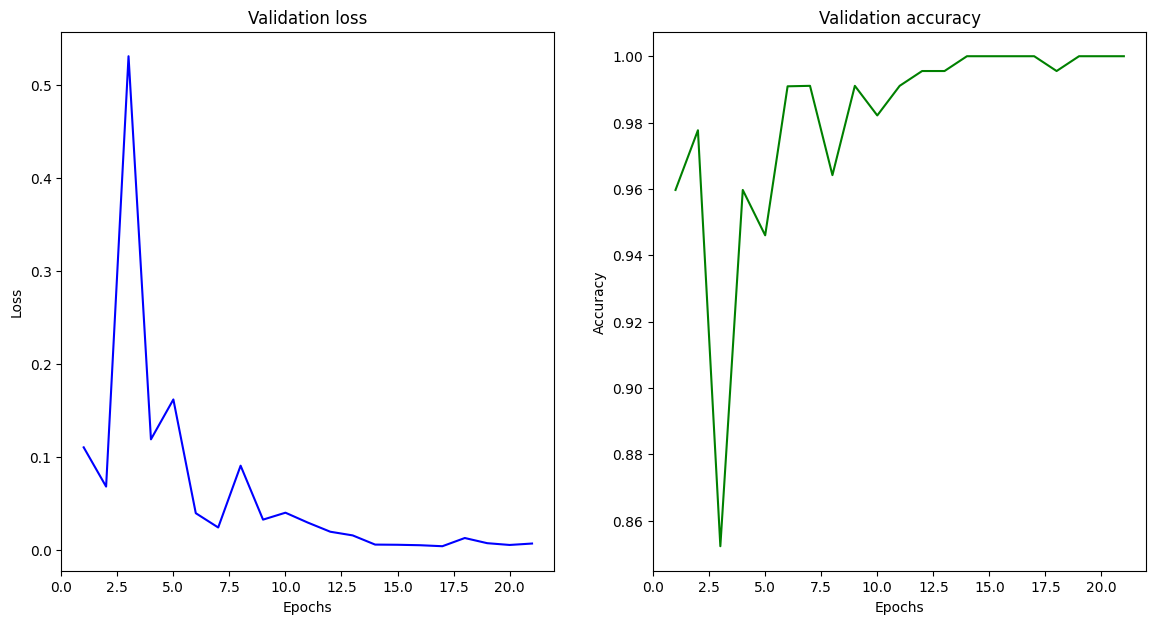

In [ ]:
losses = train(
    model=model_v2_s,
    opt=optimizer,
    loss_fn=loss_fn,
    epochs=21,
    data_tr=dataloader_train,
    data_val=dataloader_val,
    scheduler=step_lr,
)

За 21 одну эпоха модель смогла обучиться и выйти на более-менее равномерный loss. После обучения мы получили оценку по logloss = 0.0067 и точность модели accuracy = 0.995 на валидационных данных. 

## Обучение финальной модели на полных данных и получение тестовых предсказаний.

Для финальной оценки модели на тестовых данных обучим модель заново на полных тренировочных данных (train + validatition).<br>
Обучение будем проводить на 19 эпохах, остальные параметры обучения будут такими же как у выбранной успешной модели. 

In [ ]:
gc.collect()

torch.cuda.empty_cache()

Подготовим данные

In [ ]:
batch_size = 16

data_full = FakeDataset(X, labels=Y, transform=img_transforms["train"])

dataloader_full = DataLoader(
    data_full, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

Загрузим и подготовим модель

In [ ]:
model_full = models.efficientnet_v2_s(weights_v2_s)

In [ ]:
for param in model_full.parameters():
    param.requires_grad = True

num_features = model_full.classifier[1].in_features  # 1280

model_full.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=num_features, out_features=1000, bias=True),
    nn.SiLU(inplace=True),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1000, out_features=1, bias=False),
    nn.Sigmoid(),
)

model_full = model_full.to(device)

In [ ]:
# model_full

Проверим параметры обучения и запустим его.

In [ ]:
loss_fn = nn.BCELoss()

optimizer = optim.NAdam(model_full.parameters(), lr=1e-3)

step_lr = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
model_final = train_full(
    model=model_full,
    opt=optimizer,
    loss_fn=loss_fn,
    epochs=19,
    data_full=dataloader_full,
    scheduler=step_lr,
)

Epoch:: 100%|██████████| 19/19 [10:06<00:00, 31.93s/it]

train_loss: 0.010039


**Получим предсказания на тестовых изображениях нашей моделью**

In [ ]:
final_submission = predict(test_df, model=model_final, data_root=DATA_ROOT)
final_submission

<torch.utils.data.dataloader.DataLoader object at 0x7bf05268e680> iter:: 100%|██████████| 64/64 [00:06<00:00,  9.41it/s]


id        target
0    Qt1fGUB0Vz.jpeg  3.531490e-05
1    j4Rhioq7R3.jpeg  4.113803e-03
2    rD0hgFHJUZ.jpeg  4.001932e-04
3    aY5z1EJsJ6.jpeg  1.000000e+00
4    qZ3IoxD2TE.jpeg  5.721882e-06
..               ...           ...
501       Qrme6EUmL1  1.000000e+00
502  4369Dl8wfs.jpeg  2.563957e-05
503  BrNEvRNpPu.jpeg  6.916666e-07
504  DuwXCNmeMx.webp  9.986975e-01
505  Zx8GAhtKvo.jpeg  9.999943e-01

[506 rows x 2 columns]

In [ ]:
final_submission.to_csv("my_submission.csv", index=False)

## Выводы


**У нас получилось обучить модель, которая показывает более чем 99% точности в определении сгенерированных изображений. Требуемая в работе метрика LogLoss достигла значений около 0.02.** 

**После изучения данных и выявления некоторых закономерностей было проверено несколько различных вариантов решения. В итоге рабочей моделью стала дообученная модель `EfficientNet_V2_S`. Для обучения использовались только полученные данные этого проекта. На public части тестовых данных оценка модели была 0.05433, на private части оценка - 0.00467**